In [12]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

In [13]:
## GET WEIGHT AND WATER DATA FOR ALL IBL SUBJECTS
subj = subject.Subject * subject.SubjectLab & \
        (subject.SubjectProject & 'subject_project = "ibl_neuropixel_brainwide_01"') 

# average watering and weight per session date
weight_with_date = subj * action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')\

# combine all
b = subj  * avg_weight_date * total_water_date
b = b.proj('subject_nickname', 'subject_birth_date','sex', 'lab_name', 'avg_weight', 'total_water', 'watertype')
df = pd.DataFrame(b.fetch(as_dict=True))

# errors in the database; throw away crazy weights
df = df[~(df['avg_weight'] > 80)] 
df = df[~(df['avg_weight'] < 10)] 

In [14]:
# FOR EACH LAB, WHAT'S THE WEEKEND WATER REGIME?
lab_watermap = {}
for name, group in df.groupby(['lab_name']):
    #print(name)
    #print(group.watertype.unique())
    matching = [s for s in group.watertype if "Citric" in s]
    if not len(matching) == 0:
        lab_watermap.update({name:'CA'})
    else:
        lab_watermap.update({name:'restr'})

df['weekend_water_regime'] = df['lab_name'].map(lab_watermap)
df.weekend_water_regime.unique()

array(['restr', 'CA'], dtype=object)

In [15]:
## ADD INFO ABOUT WATER RESTRICTIONS PER MOUSE
weight_normalized = pd.DataFrame([])
for index, sjdatgr in df.groupby(['subject_nickname']):
    sjdat = sjdatgr.copy() # avoid copy warnings
    
    # add normalized weights (from mean per sj) and days from first weighing
    # sjdat['norm_weight'] = sjdat['avg_weight'] / sjdat['avg_weight'].mean()
    sjdat['days_weight'] = sjdat['session_date'] - sjdat['session_date'].min()
    
    # FOR EACH ANIMAL, ADD THEIR WATER RESTRICTION DATES AND REFERENCE WEIGHT
    subj_q = (subject.Subject & 'subject_nickname="%s"'%index) \
                & ( subject.SubjectLab & 'lab_name="%s"'%sjdat.lab_name.unique().item())
    restrictions = (action.WaterRestriction & subj_q).proj(
        'reference_weight',
        restriction_start_date='DATE(restriction_start_time)', 
        restriction_end_date='DATE(restriction_end_time)')
    restrictions = restrictions.fetch(format='frame').reset_index()
    
    # MAKE A NEW COLUMN THAT INDICATES THE START AND END OF WATER RESTRICTION
    if len(restrictions) > 0:
        
        # TAKE ONLY THE FIRST WATER RESTRICTION
        if len(restrictions) > 1:
            restrictions = restrictions.sort_values(by=['restriction_start_date']).head(n=1)
            
        if any(restrictions.restriction_end_date.isnull()):
            # print(subj_q.fetch1('subject_nickname'))
            print('%s''s first WR has no end date'%subj_q.fetch1('subject_nickname'))
        else:

            # look at weight curves as a function the animal's reference weight
            sjdat['norm_weight'] = sjdat['avg_weight'] / restrictions.reference_weight.item()
            
            # new date axis, linearly spaced
            restr_dates_linear = pd.DataFrame(pd.date_range(restrictions.restriction_start_date.item(), 
                                            restrictions.restriction_end_date.item()
                                                        )).reset_index().rename(columns={'index': 'day_restr', 0: 'session_date'})
            # ensure these are the same format before merge
            restr_dates_linear['session_date'] = restr_dates_linear['session_date'].dt.date
            # sjdat['session_date'] = sjdat['session_date'].dt.date
            sjdat = sjdat.merge(restr_dates_linear.set_index('session_date'), on=['session_date'])
            weight_normalized = weight_normalized.append(sjdat)

    else:
        print('%s has no WRs logged'%subj_q.fetch1('subject_nickname'))

# make into a new dataframe
df = weight_normalized.copy()

CSH_ZAD_002s first WR has no end date
CSH_ZAD_005s first WR has no end date
CSH_ZAD_006s first WR has no end date
CSH_ZAD_007s first WR has no end date
CSH_ZAD_010s first WR has no end date
CSH_ZAD_011s first WR has no end date
CSH_ZAD_015s first WR has no end date
CSH_ZAD_016s first WR has no end date
CSH_ZAD_017s first WR has no end date
CSH_ZAD_018s first WR has no end date
CSH_ZAD_019s first WR has no end date
CSH_ZAD_021s first WR has no end date
CSH_ZAD_022s first WR has no end date
CSH_ZAD_024s first WR has no end date
CSH_ZAD_23s first WR has no end date
CSK-IBL-002s first WR has no end date
CSK-IBL-004s first WR has no end date
DY_008s first WR has no end date
DY_009s first WR has no end date
DY_010s first WR has no end date
DY_011s first WR has no end date
DY_012s first WR has no end date
DY_013s first WR has no end date
DY_014s first WR has no end date
DY_015s first WR has no end date
IBL_001s first WR has no end date
IBL_002s first WR has no end date
IBL_003s first WR has n

In [16]:
# compute age range
df['session_age'] = (df.session_date - df.subject_birth_date)

## ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
df['days_weight']  = df['days_weight'].dt.days

df.session_age.describe()

count                        5607
mean     126 days 07:20:42.375601
std       37 days 23:11:51.163320
min              43 days 00:00:00
25%              98 days 00:00:00
50%             119 days 00:00:00
75%             149 days 00:00:00
max             275 days 00:00:00
Name: session_age, dtype: object

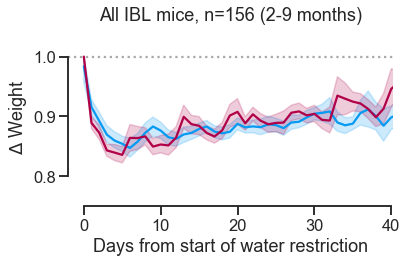

In [19]:
## NOW PLOT

condition_order = [ "restr", "CA"]
palette = sns.xkcd_palette(['azure', 'raspberry'])
f, ax = plt.subplots(ncols=1, nrows=1, figsize=[6, 4])

# df_group = df.groupby(['lab_name', 'day_restr', 'weekend_water_regime'])['avg_weight'].mean().reset_index()
# sns.lineplot(data=df_group, x='day_restr', y='avg_weight', hue='weekend_water_regime', 
#                  palette=palette, hue_order=condition_order, ax=ax[0], legend=False)
# ax[0].set_xlim([-2, 40])

df_group = df.groupby(['lab_name', 'day_restr', 'weekend_water_regime'])['norm_weight'].mean().reset_index()
sns.lineplot(data=df, x='day_restr', y='norm_weight', hue='weekend_water_regime', 
                 palette=palette, hue_order=condition_order, ax=ax, legend=False, 
                err_style='band')
# sns.lineplot(data=df, x='day_restr', y='norm_weight', hue='weekend_water_regime', 
#                  palette=palette, hue_order=condition_order, ax=ax, legend=False, 
#                 estimator=None, units='subject_nickname', alpha=0.05)
ax.set_xlim([-2, 40.2])
ax.set_ylim([0.75, 1.05])
ax.axhline(y=1, color='darkgrey', linestyle=':', zorder=-100)
ax.set_title('All IBL mice, n=%d (2-9 months)'%df.subject_uuid.nunique())
ax.set(xlabel='Days from start of water restriction', ylabel="$\Delta$ Weight")

sns.despine(trim=True)
f.tight_layout()
f.savefig(os.path.join(figpath, "ibl_weightcurves.pdf"))

In [18]:
df.session_age.describe()

count                        5607
mean     126 days 07:20:42.375601
std       37 days 23:11:51.163320
min              43 days 00:00:00
25%              98 days 00:00:00
50%             119 days 00:00:00
75%             149 days 00:00:00
max             275 days 00:00:00
Name: session_age, dtype: object

 ## part 2: add performance data

In [28]:
# get session with date
session_with_date = behavior.TrialSet.proj('n_trials') \
    * (acquisition.Session.proj(session_date='DATE(session_start_time)'))
b = subj * session_with_date * avg_weight_date * total_water_date
b = b.proj('subject_nickname', 'subject_birth_date','sex', 'lab_name', 'avg_weight', 
           'total_water', 'watertype', 'n_trials')
df2 = pd.DataFrame(b.fetch(as_dict=True))

# errors in the database; throw away crazy weights
df2 = df2[~(df2['avg_weight'] > 80)] 
df2 = df2[~(df2['avg_weight'] < 10)] 

# FOR EACH LAB, WHAT'S THE WEEKEND WATER REGIME?
df2['weekend_water_regime'] = df2['lab_name'].map(lab_watermap)

## ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df2['session_date'] = pd.to_datetime(df2.session_date)
df2['week_number']  = df2['session_date'].dt.week
df2['weekday_name'] = df2['session_date'].dt.day_name()

In [27]:
df2

,subject_uuid,session_start_time,session_date,subject_nickname,sex,subject_birth_date,lab_name,n_trials,avg_weight,total_water,watertype,weekend_water_regime,week_number,weekday_name
0,00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-10 11:24:59,2019-08-10,KS019,F,2019-04-30,cortexlab,196,19.900000,0.8160,Water; Water 10% Sucrose,restr,32,Saturday
1,00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-12 09:21:03,2019-08-12,KS019,F,2019-04-30,cortexlab,140,20.500000,0.7880,Water; Water 10% Sucrose,restr,33,Monday
2,00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-13 10:28:45,2019-08-13,KS019,F,2019-04-30,cortexlab,223,20.000000,0.7730,Water; Water 10% Sucrose,restr,33,Tuesday
3,00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 09:37:17,2019-08-14,KS019,F,2019-04-30,cortexlab,55,19.700001,0.7680,Water; Water 10% Sucrose,restr,33,Wednesday
4,00778394-c956-408d-8a6c-ca3b05a611d5,2019-08-14 11:35:16,2019-08-14,KS019,F,2019-04-30,cortexlab,289,19.700001,0.7680,Water; Water 10% Sucrose,restr,33,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9074,ffcd8c5e-fe0c-4d6d-8418-d9152f1746f1,2020-01-17 10:12:49,2020-01-17,ZM_2240,M,2019-08-12,mainenlab,821,21.320000,1.9870,Water 10% Sucrose; Water 2% Citric Acid,CA,3,Friday
9075,ffcd8c5e-fe0c-4d6d-8418-d9152f1746f1,2020-01-21 10:44:49,2020-01-21,ZM_2240,M,2019-08-12,mainenlab,427,21.299999,0.5205,Water 10% Sucrose,CA,4,Tuesday
9076,ffcd8c5e-fe0c-4d6d-8418-d9152f1746f1,2020-01-22 10:51:00,2020-01-22,ZM_2240,M,2019-08-12,mainenlab,646,20.700001,0.8265,Water 10% Sucrose,CA,4,Wednesday
9077,ffcd8c5e-fe0c-4d6d-8418-d9152f1746f1,2020-01-23 15:12:03,2020-01-23,ZM_2240,M,2019-08-12,mainenlab,1075,19.799999,1.3710,Water 10% Sucrose,CA,4,Thursday


In [100]:
## FOR EACH FRIDAY-MONDAY PAIR, COMPUTE DIFFERENCE IN TRIAL COUNTS AND WEIGHT
# https://github.com/int-brain-lab/analysis/blob/a091b4c2ffcebe83cfb89914d171ebf9acbbadf5/plotting/weightmonitoring_citricacid.ipynb

df3 = []
for index, sjdatgr in df2.groupby(['lab_name', 'subject_nickname', 'week_number']):
    sjdat = sjdatgr.copy() # avoid copy warnings
    
    # what are the values at the end of this week?
    weight_friday  = sjdat[sjdat.weekday_name.isin(['Friday'])]['avg_weight'].mean()
    ntrials_friday = sjdat[sjdat.weekday_name.isin(['Friday'])]['n_trials'].mean()
    date_friday    = sjdat[sjdat.weekday_name.isin(['Friday'])]['session_date'].unique()
    
    # skip if there is no friday to be found
    if len(date_friday) == 0:
        continue

    date_monday    = (date_friday+pd.Timedelta('3 days')).astype('datetime64[s]').tolist()
    
    # and what are the values at the beginning of the next week?
    nextweek = df2[df2.subject_nickname.isin([sjdat.subject_nickname.unique().item()]) & 
                  df2.lab_name.isin([sjdat.lab_name.unique().item()]) & 
                  df2['session_date'].isin(date_monday)]
    
    weight_monday = nextweek['avg_weight'].mean()
    ntrials_monday = nextweek['n_trials'].mean()
    # print(len(nextweek))
    
    df3.append({'lab_name':sjdat.lab_name.unique().item(),
                            'subject_nickname':sjdat.subject_nickname.unique().item(), 
                            'weekend_water_regime':sjdat.weekend_water_regime.unique().item(), 
                            'week_number':sjdat.week_number.unique().item(), 
                            'weight_change':weight_monday - weight_friday,
                            'ntrials_change':ntrials_monday - ntrials_friday})
df3 = pd.DataFrame(df3)
df3

,lab_name,subject_nickname,weekend_water_regime,week_number,weight_change,ntrials_change
0,angelakilab,IBL-T1,CA,7,-0.400000,-1083.0
1,angelakilab,IBL-T1,CA,8,NaN,NaN
2,angelakilab,IBL-T1,CA,9,NaN,NaN
3,angelakilab,IBL-T1,CA,10,0.670000,94.0
4,angelakilab,IBL-T1,CA,11,0.209999,-254.0
...,...,...,...,...,...,...
1727,zadorlab,CSH_ZAD_024,CA,12,NaN,NaN
1728,zadorlab,CSH_ZAD_23,CA,9,1.455000,144.0
1729,zadorlab,CSH_ZAD_23,CA,10,1.719999,-12.0
1730,zadorlab,CSH_ZAD_23,CA,11,1.640001,-73.0


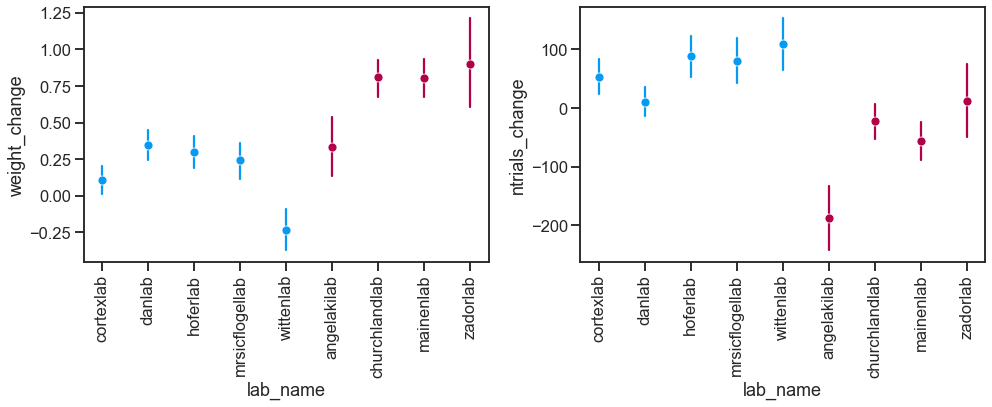

In [125]:
## plot
condition_order = [ "restr", "CA"]
palette = sns.xkcd_palette(['azure', 'raspberry'])
f, ax = plt.subplots(ncols=2, nrows=1, figsize=[14, 6])

sns.lineplot(x="lab_name", y="weight_change", hue="weekend_water_regime",
               data=df3, err_style='bars', marker='o', linewidth=0, legend=False, ax=ax[0],
            palette=palette, hue_order=condition_order)
sns.lineplot(x="lab_name", y="ntrials_change", hue="weekend_water_regime",
               data=df3, err_style='bars', marker='o', linewidth=0, legend=False, ax=ax[1], 
            palette=palette, hue_order=condition_order)

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90)

#sns.despine(trim=True)
f.tight_layout()